## Cargamos programas base y librerías

In [ ]:
%run ../base_notebook.ipynb
%run ../base_descargar_datos_estacion.ipynb
%run ../base_dataset_generation.ipynb

In [ ]:
import requests
import pandas as pd
import json
import datetime
from datetime import timedelta
import warnings
import datetime as dt
from sklearn.impute import KNNImputer
from loguru import logger 
import time
import os
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import pandas as pd
import glob
import math

def RMSE(real,predicted):
    return(math.sqrt(((predicted + real).sum())/len(predicted)))

plt.style.use('seaborn')

### Datos de $NO_2$ (Estación de referencia y dispositivo)

In [2]:
NO2 = pd.read_csv('new_NO2_correct.csv')
NO2['date'] = pd.to_datetime(NO2['date'])

NO2

,Unnamed: 0,date,NO2_Reference,NO2
0,7,2021-10-20 20:00:00,9.95,9.93852
1,8,2021-10-20 21:00:00,10.47,10.28428
2,10,2021-10-20 23:00:00,3.66,5.94876
3,12,2021-10-21 01:00:00,7.33,8.47304
4,14,2021-10-21 03:00:00,24.08,21.15156
...,...,...,...,...
285,430,2021-11-08 13:00:00,6.81,12.16840
286,433,2021-11-08 16:00:00,14.14,22.82608
287,437,2021-11-08 20:00:00,50.79,49.15004
288,438,2021-11-08 21:00:00,47.64,47.47040


### Descargamos datasets de la base de datos descomentando la MAC del dispositivo.

In [4]:
nombre_dataset_salida = 'Test_Prueba.csv'
nombre_dataset_base = 'Test_Prueba'

# AQ1 = 'HOP246f28de3f82'; dst_path = 'plantower.json' # PMS7003 DESCARTADO
# AQ1 = 'HOP246f28de4032'; dst_path = 'nova.json' # PM_NOVA_SDS011_BIS # DESCARTADO NO TIENE PM1
AQ1 = 'HOP246f28de423a'; dst_path = 'winsen.json' # Winsen_ZH03B_2
# AQ1 = 'HOP840d8ee6e89e'; dst_path = 'winsen.json' # Winsen_ZH03B
# AQ1 = 'HOPac67b2cd1c8a'; dst_path = 'opc.json' # Alphasense OPC-N3

# date_in = '2022-03-18 23:00:00'    # TUBO 30 CM
# date_out = '2022-03-21 09:00:00'

# date_in = '2022-03-01 00:00:00'    # TUBO 20 CM
# date_out = '2022-03-14 00:00:00'

# date_in = '2022-01-25 00:00:00'    # TUBO 1 M
# date_out = '2022-01-26 00:00:00'

date_in = '2022-01-17 00:00:00'    # CONDICIONES NORMALES
date_out = '2022-01-21 00:00:00'


descargar = True
interpolar_datos_perdidos = True
division_dias_dataset = 15
eliminar_outlier = True

In [5]:
print(dst_path)

with open(dst_path) as json_file:
        column_names = json.load(json_file)
               
dst_path =  "database_small.json"

with open(dst_path) as json_file:
        database = json.load(json_file)

print(column_names)

exporter = Exporter(query_division = 1, column_names = column_names, database = database)

homard = exporter.main_function_v3(table = '\\"homard\\".\\"values_precrash\\"', endpoint = AQ1, date_in = date_in, date_out = date_out, mean = 'minute')
homard.index = pd.to_datetime(homard.date) 

homard = homard.resample('1T').mean()
homard['date'] = homard.index
homard.index = range(len(homard.index))

display(homard)

winsen.json
{'PM1': '/32993/0/0', 'PM2_5': '/32993/0/1', 'PM10': '/32993/0/2'}
               TIME   PM1  PM2_5  PM10
0     1642377600000  10.0   13.0  14.0
1     1642377660000  10.0   13.0  14.0
2     1642377720000  11.0   14.0  15.0
3     1642377780000  11.0   14.0  15.0
4     1642377840000  11.0   14.0  15.0
...             ...   ...    ...   ...
1430  1642722900000  26.0   32.0  36.0
1431  1642722960000  25.0   31.0  35.0
1432  1642723020000  25.0   31.0  35.0
1433  1642723080000  25.0   31.0  35.0
1434  1642723140000  25.0   32.0  36.0

[5683 rows x 4 columns]


,TIME,PM1,PM2_5,PM10,date
0,1.642378e+12,10.0,13.0,14.0,2022-01-17 00:00:00+00:00
1,1.642378e+12,10.0,13.0,14.0,2022-01-17 00:01:00+00:00
2,1.642378e+12,11.0,14.0,15.0,2022-01-17 00:02:00+00:00
3,1.642378e+12,11.0,14.0,15.0,2022-01-17 00:03:00+00:00
4,1.642378e+12,11.0,14.0,15.0,2022-01-17 00:04:00+00:00
...,...,...,...,...,...
5755,1.642723e+12,26.0,32.0,36.0,2022-01-20 23:55:00+00:00
5756,1.642723e+12,25.0,31.0,35.0,2022-01-20 23:56:00+00:00
5757,1.642723e+12,25.0,31.0,35.0,2022-01-20 23:57:00+00:00
5758,1.642723e+12,25.0,31.0,35.0,2022-01-20 23:58:00+00:00


### Matriz de correlaciones de estación de referencia y dispositivo

In [6]:
display(homard.corr())

,TIME,PM1,PM2_5,PM10
TIME,1.000000,0.277449,0.277010,0.277415
PM1,0.277449,1.000000,0.999809,0.999742
PM2_5,0.277010,0.999809,1.000000,0.999895
PM10,0.277415,0.999742,0.999895,1.000000


### Lectura de ficheros del GRIMM

In [7]:
grimm = pd.DataFrame()

for file in os.listdir('./GRIMM_General/'):
    
    
    try:
        grimm = pd.concat([grimm,pd.read_csv(f'./GRIMM_General/{file}')])
    except: 
        pass

grimm['Date'] = pd.to_datetime(grimm['Date'], utc = True , dayfirst = True) - timedelta(hours = 1)
grimm.index = grimm.Date
grimm = grimm.resample('1T').mean()

grimm['date'] = grimm.index
grimm.index = range(len(grimm.index))

display(grimm)

,TSP_Reference,PM10_Reference,PM4_Reference,"PM2,5_Reference",PM1_Reference,PMcoarse_Reference,Inhalable_Reference,Thoracic_Reference,Respirable_Reference,pm10-IAQ_Reference,"pm2,5-IAQ_Reference",pm1-IAQ_Reference,date
0,71.2,61.1,53.6,46.8,41.5,14.3,57.9,53.3,43.4,53.2,37.4,33.4,2022-01-14 07:29:00+00:00
1,100.0,71.7,65.9,60.6,55.0,11.0,76.1,64.1,53.2,60.7,48.4,44.3,2022-01-14 07:30:00+00:00
2,51.2,45.8,41.0,37.0,33.2,8.8,42.4,40.0,33.3,39.6,29.6,26.7,2022-01-14 07:31:00+00:00
3,42.9,34.8,30.6,25.5,21.2,9.4,34.6,31.2,24.8,30.0,20.3,17.1,2022-01-14 07:32:00+00:00
4,84.1,33.5,29.5,24.5,19.8,9.0,47.5,28.8,23.8,28.8,19.5,16.0,2022-01-14 07:33:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95013,32.0,32.0,29.4,21.8,10.1,10.2,25.3,25.3,22.9,25.3,16.8,8.1,2022-03-21 07:02:00+00:00
95014,32.2,30.4,27.8,21.1,10.1,9.3,25.4,24.6,21.5,24.4,16.3,8.1,2022-03-21 07:03:00+00:00
95015,33.9,33.2,30.3,22.2,9.8,11.0,26.7,26.4,23.4,26.5,17.1,7.8,2022-03-21 07:04:00+00:00
95016,49.0,33.5,30.7,23.2,10.0,10.3,34.1,27.7,23.8,27.0,17.8,7.9,2022-03-21 07:05:00+00:00


### Merge entre dataset de la base de datos y GRIMM para igualar los datos horarios

In [8]:
final_data = homard.merge(grimm, on = 'date')
display(final_data)

,TIME,PM1,PM2_5,PM10,date,TSP_Reference,PM10_Reference,PM4_Reference,"PM2,5_Reference",PM1_Reference,PMcoarse_Reference,Inhalable_Reference,Thoracic_Reference,Respirable_Reference,pm10-IAQ_Reference,"pm2,5-IAQ_Reference",pm1-IAQ_Reference
0,1.642378e+12,10.0,13.0,14.0,2022-01-17 00:00:00+00:00,36.3,32.4,29.5,27.3,25.5,5.1,29.8,28.0,24.0,27.7,22.0,20.6
1,1.642378e+12,10.0,13.0,14.0,2022-01-17 00:01:00+00:00,35.7,32.6,29.7,27.3,25.3,5.3,29.3,28.0,24.0,27.8,22.0,20.5
2,1.642378e+12,11.0,14.0,15.0,2022-01-17 00:02:00+00:00,31.9,31.9,30.6,28.3,26.1,3.6,26.1,26.1,24.7,26.1,22.7,21.1
3,1.642378e+12,11.0,14.0,15.0,2022-01-17 00:03:00+00:00,53.2,33.4,30.2,27.5,25.3,5.9,38.3,30.0,24.5,28.6,22.1,20.4
4,1.642378e+12,11.0,14.0,15.0,2022-01-17 00:04:00+00:00,158.3,33.9,30.7,28.2,25.8,5.7,78.3,31.4,24.8,29.1,22.6,20.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,1.642723e+12,26.0,32.0,36.0,2022-01-20 23:55:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5756,1.642723e+12,25.0,31.0,35.0,2022-01-20 23:56:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5757,1.642723e+12,25.0,31.0,35.0,2022-01-20 23:57:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5758,1.642723e+12,25.0,31.0,35.0,2022-01-20 23:58:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
display(final_data.corr())
final_data.to_csv('PM1_GRIMM.csv')

,TIME,PM1,PM2_5,PM10,TSP_Reference,PM10_Reference,PM4_Reference,"PM2,5_Reference",PM1_Reference,PMcoarse_Reference,Inhalable_Reference,Thoracic_Reference,Respirable_Reference,pm10-IAQ_Reference,"pm2,5-IAQ_Reference",pm1-IAQ_Reference
TIME,1.000000,0.277449,0.277010,0.277415,0.019507,0.079371,0.112021,0.138101,0.154287,-0.032065,0.030177,0.059787,0.110237,0.061958,0.139880,0.154885
PM1,0.277449,1.000000,0.999809,0.999742,0.479080,0.808909,0.914437,0.952595,0.956515,0.296453,0.535468,0.715380,0.906940,0.730753,0.953280,0.956530
PM2_5,0.277010,0.999809,1.000000,0.999895,0.479177,0.809095,0.914635,0.952805,0.956745,0.296535,0.535569,0.715541,0.907142,0.730934,0.953491,0.956759
PM10,0.277415,0.999742,0.999895,1.000000,0.479821,0.809438,0.914764,0.952790,0.956660,0.297236,0.536203,0.716021,0.907295,0.731386,0.953470,0.956673
TSP_Reference,0.019507,0.479080,0.479177,0.479821,1.000000,0.801194,0.673394,0.544898,0.480865,0.837247,0.966650,0.860060,0.689530,0.844514,0.540601,0.480540
PM10_Reference,0.079371,0.808909,0.809095,0.809438,0.801194,1.000000,0.962061,0.882860,0.833646,0.769084,0.861665,0.984988,0.969572,0.989679,0.879702,0.833365
PM4_Reference,0.112021,0.914437,0.914635,0.914764,0.673394,0.962061,1.000000,0.976520,0.950025,0.566857,0.736581,0.901964,0.999530,0.913240,0.974982,0.949832
"PM2,5_Reference",0.138101,0.952595,0.952805,0.952790,0.544898,0.882860,0.976520,1.000000,0.994599,0.378831,0.606062,0.792715,0.970237,0.808046,0.999963,0.994500
PM1_Reference,0.154287,0.956515,0.956745,0.956660,0.480865,0.833646,0.950025,0.994599,1.000000,0.289194,0.539975,0.732305,0.941521,0.749031,0.995380,0.999993
PMcoarse_Reference,-0.032065,0.296453,0.296535,0.297236,0.837247,0.769084,0.566857,0.378831,0.289194,1.000000,0.873171,0.862186,0.590210,0.850566,0.372655,0.288775


## Visualización de datos particulas


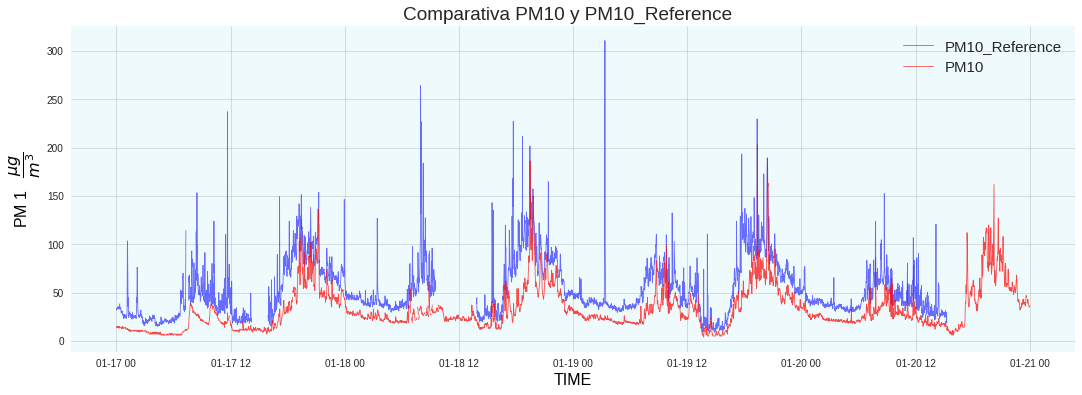

In [10]:
fig = plt.figure(figsize = (18,6))

plt.rcParams.update({  "axes.facecolor":    (0.67 , 0.9, 0.93, 0.2)  })


plt.grid(alpha = 0.3, color = 'gray' , linestyle = '-' , linewidth = '0.8')

plt.plot(final_data['date'] , final_data['PM10_Reference'] , linewidth = '0.8' ,label = 'PM10_Reference' , color = 'blue' ,alpha = 0.57)
plt.plot(final_data['date'] , final_data['PM10'] , linewidth = '0.8' ,label = 'PM10' , color = 'red' , alpha = 0.7)

plt.title('Comparativa PM10 y PM10_Reference  ' , fontsize = '19')
plt.xlabel('TIME' , color = 'black' , fontsize = '16')
plt.ylabel('PM 1   $\dfrac{\mu g}{m^{3}}$' , color = 'black' , fontsize = '16')

plt.legend(loc = "upper right" , prop={'size':15} , shadow = True , edgecolor='black' , facecolor = 'wheat' )


plt.savefig('PM10_1M_OPC.pdf',bbox_inches='tight')

## Visualización de datos gases

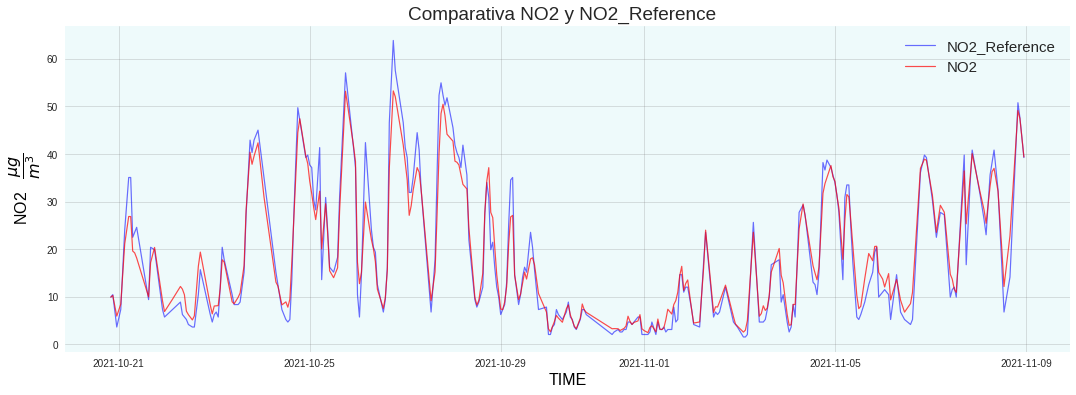

In [11]:
fig = plt.figure(figsize = (18,6))

plt.rcParams.update({  "axes.facecolor":    (0.67 , 0.9, 0.93, 0.2)  })


plt.grid(alpha = 0.3, color = 'gray' , linestyle = '-' , linewidth = '0.8')

plt.plot(NO2['date'] , NO2['NO2_Reference'] , linewidth = '1.2' ,label = 'NO2_Reference' , color = 'blue' ,alpha = 0.57)
plt.plot(NO2['date'] , NO2['NO2'] , linewidth = '1.2' ,label = 'NO2' , color = 'red' , alpha = 0.7)

plt.title('Comparativa NO2 y NO2_Reference  ' , fontsize = '19')
plt.xlabel('TIME' , color = 'black' , fontsize = '16')
plt.ylabel('NO2   $\dfrac{\mu g}{m^{3}}$' , color = 'black' , fontsize = '16')

plt.legend(loc = "upper right" , prop={'size':15} , shadow = True , edgecolor='black' , facecolor = 'wheat' )


plt.savefig('NO2_CETENMA.pdf',bbox_inches='tight')

## Modelo de regresión para recta de ajuste lineal

In [12]:
final_datos = final_data.dropna()

In [13]:
model = LinearRegression()

x = np.array(final_datos['PM10_Reference'])
y = np.array(final_datos['PM10'])

x = x.reshape((-1,1))


model.fit(x , y)
R_sq = model.score(x , y)

m = model.coef_            #Pendiente
ord = model.intercept_     #Ordenada en el origen
r2 = model.score(x , y)                  #Correlación

print('PM10=' , m , 'x' , 'PM10_Reference' , '+' , ord ,'      R2=' , r2)

PM10= [0.57495112] x PM10_Reference + 0.3925608966597878       R2= 0.6551902783903276


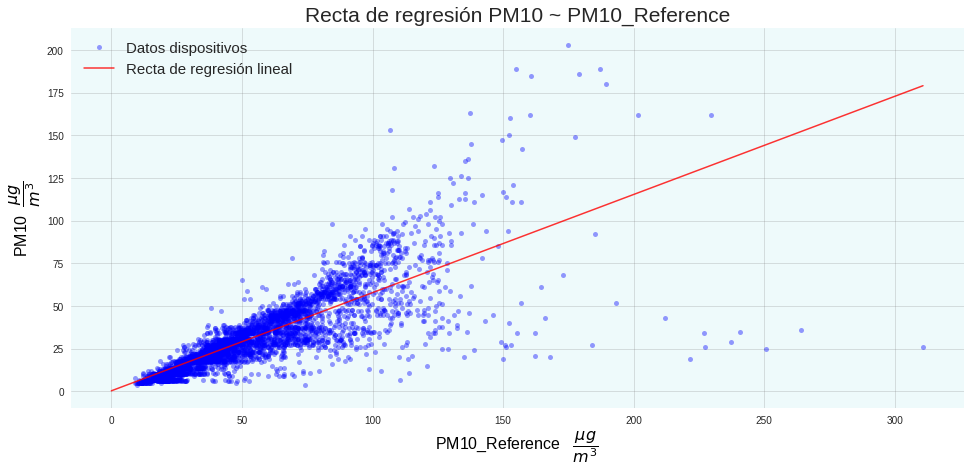

In [14]:
fig = plt.figure(figsize = (16,7))
plt.rcParams.update({  "axes.facecolor":    (0.67 , 0.9, 0.93, 0.2)  })
plt.grid(alpha = 0.3, color = 'gray' , linestyle = '-' , linewidth = '0.8')

xx = np.linspace(0, max(x) , 10)

plt.plot(final_datos['PM10_Reference'] , final_datos['PM10'], "o" ,markersize= 5 , label = 'Datos dispositivos', color = 'blue' ,alpha = 0.4)
plt.plot(xx , m*xx + ord , linewidth = '1.5' , label = 'Recta de regresión lineal', color = 'red' , alpha = 0.8)

plt.title('Recta de regresión PM10 ~ PM10_Reference' , fontsize = '21')
plt.ylabel('PM10  $\dfrac{\mu g}{m^{3}}$' , color = 'black' , fontsize = '16')
plt.xlabel('PM10_Reference   $\dfrac{\mu g}{m^{3}}$' , color = 'black' , fontsize = '16')

plt.legend(loc = "upper left" , prop={'size':15} , shadow = True , edgecolor='black' , facecolor = 'wheat')

plt.savefig('PM10_CETENMA_AJUSTE.pdf',bbox_inches='tight')

## Calculo regresion gases

In [15]:
model = LinearRegression()

x = np.array(NO2['NO2_Reference'])
y = np.array(NO2['NO2'])

x = x.reshape((-1,1))


model.fit(x , y)
R_sq = model.score(x , y)

m = model.coef_            #Pendiente
ord = model.intercept_     #Ordenada en el origen
r2 = model.score(x , y)                  #Correlación

print('NO2=' , m , 'x' , 'NO2_Reference' , '+' , ord ,'      R2=' , r2)

NO2= [0.85755445] x NO2_Reference + 2.643402089014952       R2= 0.9609277734667603


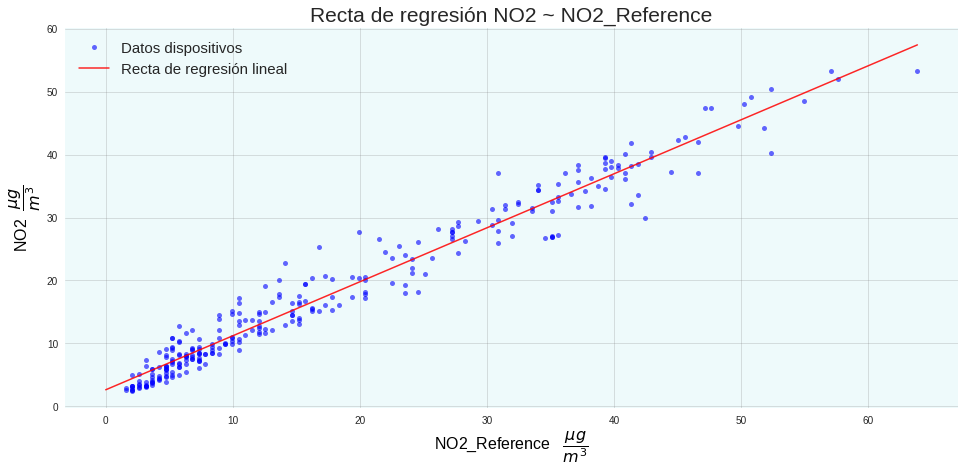

In [16]:
fig = plt.figure(figsize = (16,7))
plt.rcParams.update({  "axes.facecolor":    (0.67 , 0.9, 0.93, 0.2)  })
plt.grid(alpha = 0.3, color = 'gray' , linestyle = '-' , linewidth = '0.8')

xx = np.linspace(0, max(x) , 10)

plt.plot(NO2['NO2_Reference'] , NO2['NO2'], "o" ,markersize= 5 , label = 'Datos dispositivos', color = 'blue' ,alpha = 0.6)
plt.plot(xx , m*xx + ord , linewidth = '1.5' , label = 'Recta de regresión lineal', color = 'red' , alpha = 0.85)

plt.title('Recta de regresión NO2 ~ NO2_Reference' , fontsize = '21')
plt.ylabel('NO2  $\dfrac{\mu g}{m^{3}}$' , color = 'black' , fontsize = '16')
plt.xlabel('NO2_Reference   $\dfrac{\mu g}{m^{3}}$' , color = 'black' , fontsize = '16')

plt.legend(loc = "upper left" , prop={'size':15} , shadow = True , edgecolor='black' , facecolor = 'wheat')

plt.savefig('NO2_CETENMA_AJUSTE.pdf',bbox_inches='tight')

### Matriz de correlaciones

In [17]:
final_data.corr()

,TIME,PM1,PM2_5,PM10,TSP_Reference,PM10_Reference,PM4_Reference,"PM2,5_Reference",PM1_Reference,PMcoarse_Reference,Inhalable_Reference,Thoracic_Reference,Respirable_Reference,pm10-IAQ_Reference,"pm2,5-IAQ_Reference",pm1-IAQ_Reference
TIME,1.000000,0.277449,0.277010,0.277415,0.019507,0.079371,0.112021,0.138101,0.154287,-0.032065,0.030177,0.059787,0.110237,0.061958,0.139880,0.154885
PM1,0.277449,1.000000,0.999809,0.999742,0.479080,0.808909,0.914437,0.952595,0.956515,0.296453,0.535468,0.715380,0.906940,0.730753,0.953280,0.956530
PM2_5,0.277010,0.999809,1.000000,0.999895,0.479177,0.809095,0.914635,0.952805,0.956745,0.296535,0.535569,0.715541,0.907142,0.730934,0.953491,0.956759
PM10,0.277415,0.999742,0.999895,1.000000,0.479821,0.809438,0.914764,0.952790,0.956660,0.297236,0.536203,0.716021,0.907295,0.731386,0.953470,0.956673
TSP_Reference,0.019507,0.479080,0.479177,0.479821,1.000000,0.801194,0.673394,0.544898,0.480865,0.837247,0.966650,0.860060,0.689530,0.844514,0.540601,0.480540
PM10_Reference,0.079371,0.808909,0.809095,0.809438,0.801194,1.000000,0.962061,0.882860,0.833646,0.769084,0.861665,0.984988,0.969572,0.989679,0.879702,0.833365
PM4_Reference,0.112021,0.914437,0.914635,0.914764,0.673394,0.962061,1.000000,0.976520,0.950025,0.566857,0.736581,0.901964,0.999530,0.913240,0.974982,0.949832
"PM2,5_Reference",0.138101,0.952595,0.952805,0.952790,0.544898,0.882860,0.976520,1.000000,0.994599,0.378831,0.606062,0.792715,0.970237,0.808046,0.999963,0.994500
PM1_Reference,0.154287,0.956515,0.956745,0.956660,0.480865,0.833646,0.950025,0.994599,1.000000,0.289194,0.539975,0.732305,0.941521,0.749031,0.995380,0.999993
PMcoarse_Reference,-0.032065,0.296453,0.296535,0.297236,0.837247,0.769084,0.566857,0.378831,0.289194,1.000000,0.873171,0.862186,0.590210,0.850566,0.372655,0.288775


In [18]:
f = final_data.dropna()
# f = final_data.iloc[:,[0,1,2,4,5,6,7,8,9,10,11,12,13]].dropna() #SOLO PARA NOVA

display(f)
print("MAE PM10")
print(mean_absolute_error(f['PM10_Reference'], f['PM10']))
print("MAE PM2.5")
print(mean_absolute_error(f['PM2,5_Reference'], f['PM2_5']))
print("MAE PM1")
print(mean_absolute_error(f['PM1_Reference'], f['PM1']))

print("RMSE PM10")
print(RMSE(f['PM10_Reference'], f['PM10']))
print("RMSE PM2.5")
print(RMSE(f['PM2,5_Reference'], f['PM2_5']))
print("RMSE PM1")
print(RMSE(f['PM1_Reference'], f['PM1']))

,TIME,PM1,PM2_5,PM10,date,TSP_Reference,PM10_Reference,PM4_Reference,"PM2,5_Reference",PM1_Reference,PMcoarse_Reference,Inhalable_Reference,Thoracic_Reference,Respirable_Reference,pm10-IAQ_Reference,"pm2,5-IAQ_Reference",pm1-IAQ_Reference
0,1.642378e+12,10.0,13.0,14.0,2022-01-17 00:00:00+00:00,36.3,32.4,29.5,27.3,25.5,5.1,29.8,28.0,24.0,27.7,22.0,20.6
1,1.642378e+12,10.0,13.0,14.0,2022-01-17 00:01:00+00:00,35.7,32.6,29.7,27.3,25.3,5.3,29.3,28.0,24.0,27.8,22.0,20.5
2,1.642378e+12,11.0,14.0,15.0,2022-01-17 00:02:00+00:00,31.9,31.9,30.6,28.3,26.1,3.6,26.1,26.1,24.7,26.1,22.7,21.1
3,1.642378e+12,11.0,14.0,15.0,2022-01-17 00:03:00+00:00,53.2,33.4,30.2,27.5,25.3,5.9,38.3,30.0,24.5,28.6,22.1,20.4
4,1.642378e+12,11.0,14.0,15.0,2022-01-17 00:04:00+00:00,158.3,33.9,30.7,28.2,25.8,5.7,78.3,31.4,24.8,29.1,22.6,20.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,1.642692e+12,8.0,11.0,12.0,2022-01-20 15:15:00+00:00,27.2,19.2,18.4,17.1,15.6,2.1,20.0,16.6,14.9,15.8,13.7,12.6
5236,1.642692e+12,8.0,10.0,11.0,2022-01-20 15:16:00+00:00,143.3,29.3,22.2,17.9,15.4,11.3,64.7,29.3,18.3,27.9,14.4,12.5
5237,1.642692e+12,8.0,10.0,11.0,2022-01-20 15:17:00+00:00,20.1,20.1,18.8,16.3,14.3,3.8,16.6,16.6,15.3,16.6,13.1,11.5
5238,1.642692e+12,8.0,10.0,11.0,2022-01-20 15:18:00+00:00,20.4,19.3,16.2,14.3,13.1,5.0,17.8,17.1,13.2,17.5,11.5,10.6


MAE PM10
22.301604835348062
MAE PM2.5
12.382784493538974
MAE PM1
13.992830345977492
RMSE PM10
9.166439549019879
RMSE PM2.5
8.215295467389282
RMSE PM1
7.61467013953258


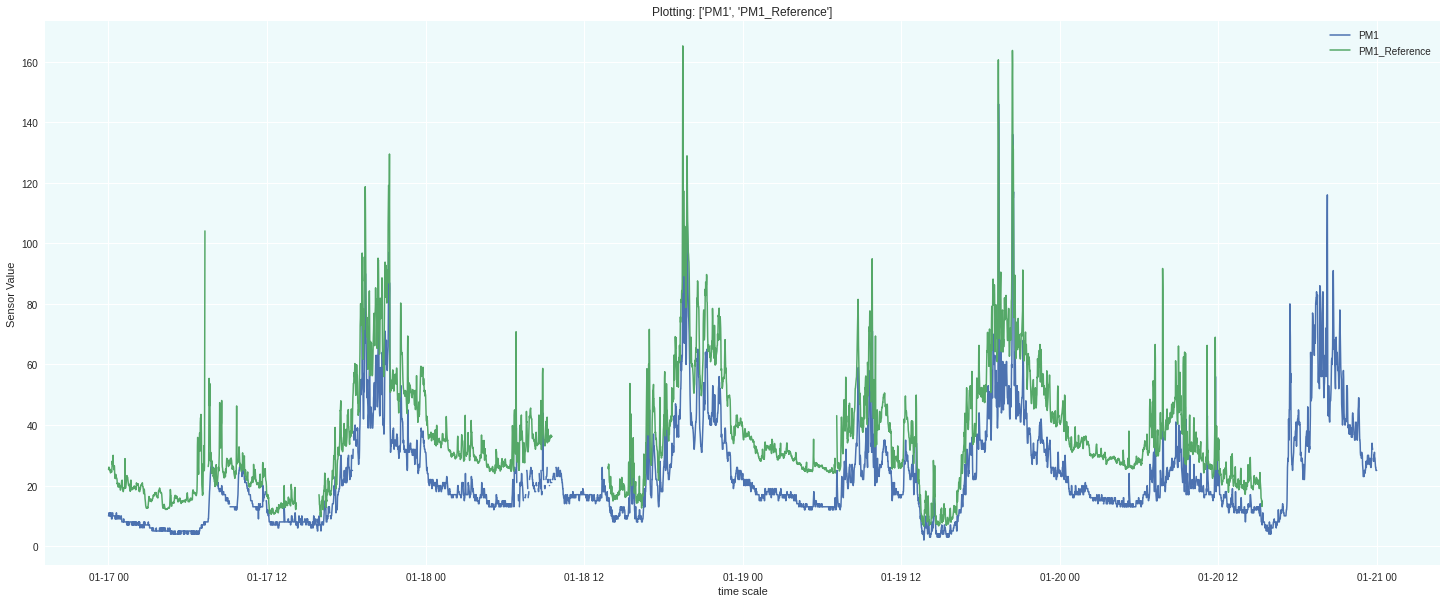

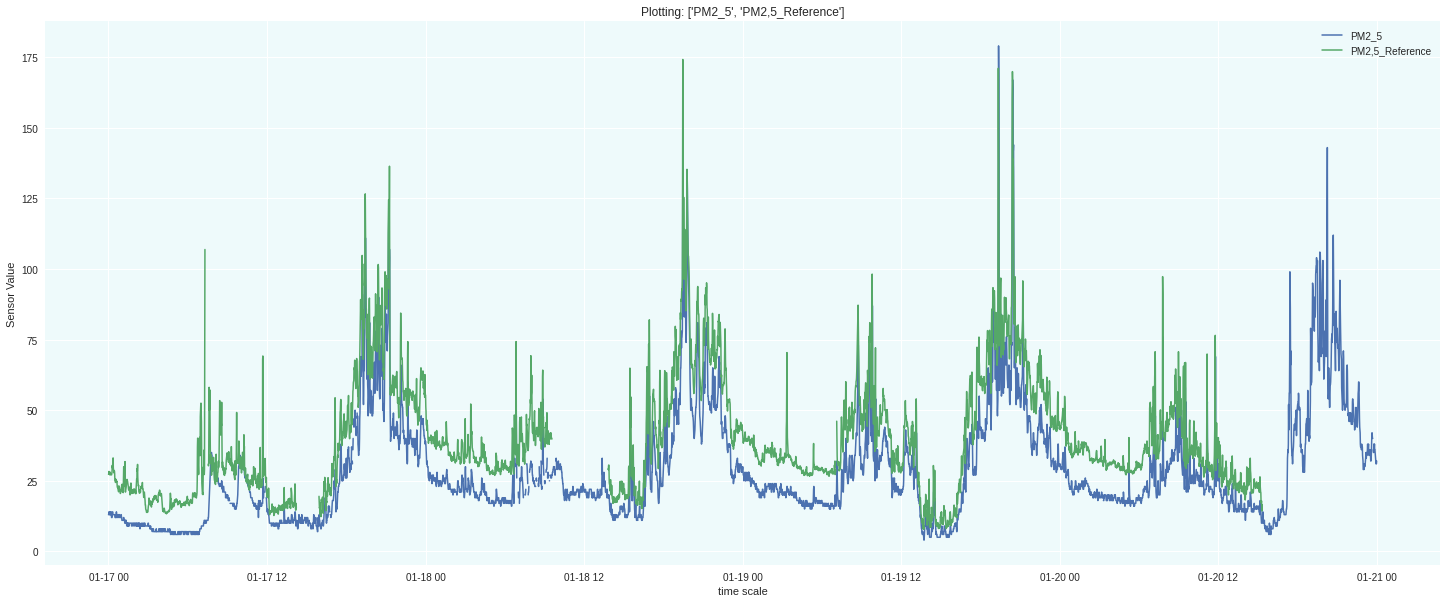

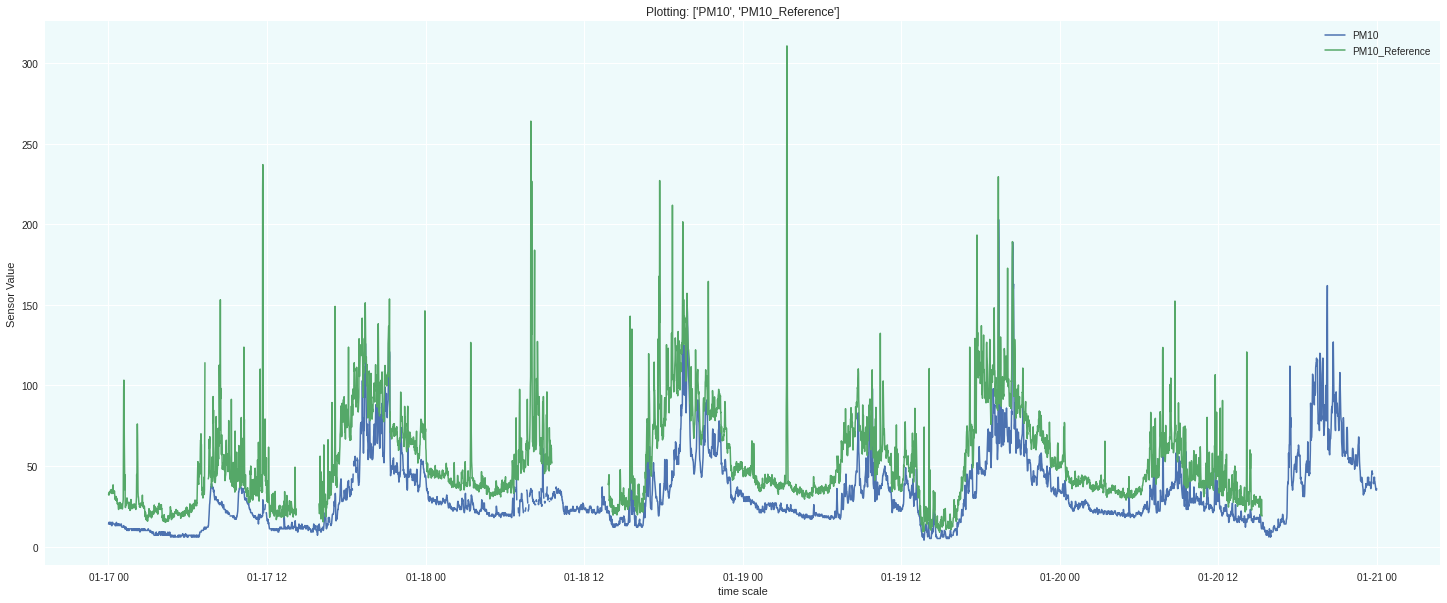

In [19]:
super_plot(final_data,'PM1','PM1_Reference')
super_plot(final_data,'PM2_5','PM2,5_Reference')
super_plot(final_data,'PM10','PM10_Reference')